# 1. Settings

In [1]:
import os
import findspark

findspark.init()

from pyspark.sql import *
from pyspark import SparkConf
from pyspark.sql.functions import *
from pyspark.sql import functions as F

In [2]:
local = "local[*]"

appName = "Scientific papers analysis app"

configLocale = SparkConf().setAppName(appName).setMaster(local). \
set("spark.executor.memory", "4G"). \
set("spark.driver.memory", "4G"). \
set("spark.sql.catalogImplementation", "in-memory")

spark = SparkSession.builder.config(conf=configLocale).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

spark

In [3]:
print("Id : ", sc.applicationId)
print("Version : ", sc.version)

Id :  local-1568364571280
Version :  2.4.3


In [4]:
# https://medium.com/@connectwithghosh/topic-modelling-with-latent-dirichlet-allocation-lda-in-pyspark-2cb3ebd5678e
import pandas as pd
import pyspark
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [5]:
# For building the model
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF
from pyspark.mllib.linalg import Vector, Vectors
#from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.ml.clustering import LDA

# 2. Data

In [9]:
path = "./Data/DataMicroTAS/"
filename = "Datas_MicroTAS2018.csv"
# Reading the data
data = sqlContext.read.format("csv")\
   .options(header='true', inferschema='true', delimiter='\t') \
   .load(os.path.realpath(path + filename))

#print(type(data), dir(data))
data.show(1)

+----------+--------------------+------------+----+--------------------+--------------------+--------------------+--------------------+
|  filename|               title|      author|date|            abstract|            keywords|                text|          references|
+----------+--------------------+------------+----+--------------------+--------------------+--------------------+--------------------+
|PG0001.pdf|ai based personal...|chih-ming ho|2018|['when', 'cancer'...|['personalized', ...|['the', 'current'...|['jaynes', 'ding'...|
+----------+--------------------+------------+----+--------------------+--------------------+--------------------+--------------------+
only showing top 1 row



In [10]:
selection = "text"
data2 = data.select("filename", F.regexp_replace(F.col(selection), "[\[\]']", "").alias(selection)) # [\$#,]
data2 = data2.select("filename", split(col(selection), ",\s*").alias(selection))
data2.show(1)
data2

+----------+--------------------+
|  filename|                text|
+----------+--------------------+
|PG0001.pdf|[the, current, dr...|
+----------+--------------------+
only showing top 1 row



DataFrame[filename: string, text: array<string>]

In [12]:
#tokens = data.select("filename", "text")
#tokens.show(2)

# 3. LDA algorithm

In [172]:
#df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])
df_txts = data2.select("filename", "text")
df_txts.show(2)
df_txts

+----------+--------------------+
|  filename|                text|
+----------+--------------------+
|PG0001.pdf|[the, current, dr...|
|PG0004.pdf|[for, inertial, m...|
+----------+--------------------+
only showing top 2 rows



DataFrame[filename: string, text: array<string>]

In [173]:
# https://github.com/vsmolyakov/pyspark/blob/master/lda.py
# TF
num_features = 8000 
cv = CountVectorizer(inputCol="text", outputCol="raw_features", vocabSize=num_features, minDF=2.0)
cvmodel = cv.fit(df_txts)

vocab = cvmodel.vocabulary

result_cv = cvmodel.transform(df_txts)
#result_cv = result_cv.drop('text')
result_cv.select("raw_features").show(2)

+--------------------+
|        raw_features|
+--------------------+
|(8000,[0,1,2,3,4,...|
|(8000,[0,1,2,3,4,...|
+--------------------+
only showing top 2 rows



In [38]:
# Hashting TF
# TF: Both HashingTF and CountVectorizer can be used to generate the term frequency vectors.
# HashingTF is a Transformer which takes sets of terms and converts those sets into fixed-length feature vectors.
# https://spark.apache.org/docs/2.2.0/ml-features.html

#hashingTF = HashingTF(inputCol="raw_features", outputCol="tf_features", numFeatures=num_features)
#result_hashing = hashingTF.transform(result_cv)
#result_hashing = newsgroups.drop('raw_features')

In [174]:
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 
#result_tfidf = result_tfidf.drop('raw_features')
result_cv.select("raw_features").show(2)

+--------------------+
|        raw_features|
+--------------------+
|(8000,[0,1,2,3,4,...|
|(8000,[0,1,2,3,4,...|
+--------------------+
only showing top 2 rows



In [179]:
from pyspark.ml.clustering import LDA
num_topics = 12

lda = LDA(k=num_topics, featuresCol="features", seed=0)
model = lda.fit(result_tfidf)

In [188]:
# https://stackoverflow.com/questions/42258926/understanding-lda-in-spark
# words by topics 
# https://stackoverflow.com/questions/53478934/pyspark-lda-get-words-in-topicss
words_topic = 30
topics = model.describeTopics(words_topic) 
topics.show()
    
model.topicsMatrix()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[1898, 3246, 3468...|[0.02274197800821...|
|    1|[16, 22, 48, 69, ...|[0.00500314199675...|
|    2|[492, 487, 443, 4...|[0.02390243273907...|
|    3|[302, 1306, 721, ...|[0.00582053031667...|
|    4|[234, 66, 146, 20...|[0.01161521049208...|
|    5|[993, 1641, 148, ...|[0.00734704577482...|
|    6|[48, 3473, 1598, ...|[0.00711728711204...|
|    7|[72, 140, 213, 16...|[0.00805355519577...|
|    8|[614, 775, 316, 1...|[0.00698549359581...|
|    9|[1377, 1053, 1770...|[0.01041406570483...|
|   10|[85, 236, 983, 40...|[0.02685210819708...|
|   11|[145, 325, 54, 12...|[0.00351899485300...|
+-----+--------------------+--------------------+



DenseMatrix(8000, 12, [1.485, 1.4188, 1.3218, 1.0516, 1.2553, 0.7525, 1.0069, 1.4014, ..., 1.0809, 0.5618, 0.5973, 0.8915, 2.7706, 0.5982, 1.2325, 2.5687], 0)

In [189]:
# Visualizing topics with spark LDA
# https://stackoverflow.com/questions/44233862/visualizing-topics-with-spark-lda

topics_rdd = topics.rdd

topics_words = topics_rdd \
   .map(lambda row: row['termIndices']) \
   .map(lambda idx_list: [vocab[idx] for idx in idx_list]) \
   .collect()

topics_words_weights = topics_rdd \
   .map(lambda row: row['termWeights']) \
   .collect()

for idx, topic in enumerate(topics_words):
    print("topic: ", idx)
    print("----------")
    for word in topic:
        print(word)
    print("----------")

topic:  0
----------
noa
mbs
gdna
atp
dibs
mip
rsd
pla
confinement
mfps
carrier
pods
reconfigurable
dib
nanocapillary
icp
microneedles
proton
mfp
electrodeposition
sticky
receiver
imposing
probes
sonication
display
streaming
probe
clustering
ultrasound
----------
topic:  1
----------
cells
cell
droplet
membrane
droplets
culture
hydrogel
fig
lm
printing
tissue
blood
printed
µm
viability
µl
array
the
platform
device
agarose
sample
media
chamber
gel
fbs
liquid
volume
fiber
lipid
----------
topic:  2
----------
imposing
none
quite
plus
normalise
trim
pddoc
trimandshift
option
page
agnws
pages
alldoc
advanced
shift
points
move
fixed
up
subdoc
biomaterial
wheel
range
wound
top
stromal
no
both
printhead
epithelium
----------
topic:  3
----------
oxygen
bbb
silica
valve
endothelial
fibers
powder
earthworm
piezoelectric
huvecs
muscle
igg
parylene
tile
sheet
building
compound
actuator
gelma
channel
root
micro
construct
force
pdms
bone
teer
elisa
blocks
oocytes
----------
topic:  4
----------
foc

# 4. Display

In [194]:
from wordcloud import WordCloud, STOPWORDS
#https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html
#https://www.datacamp.com/community/tutorials/wordcloud-python

import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image

print(topics_words[0])
my_rounded_list = [ math.floor(elem*1000) for elem in topics_words_weights[0]]
print(my_rounded_list)

['noa', 'mbs', 'gdna', 'atp', 'dibs', 'mip', 'rsd', 'pla', 'confinement', 'mfps', 'carrier', 'pods', 'reconfigurable', 'dib', 'nanocapillary', 'icp', 'microneedles', 'proton', 'mfp', 'electrodeposition', 'sticky', 'receiver', 'imposing', 'probes', 'sonication', 'display', 'streaming', 'probe', 'clustering', 'ultrasound']
[22, 10, 10, 10, 6, 5, 5, 5, 5, 5, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1]


In [197]:
#
# https://stackoverflow.com/questions/43954114/python-wordcloud-repetitve-words

def create_word_cloud(string):
    maskArray = np.array(Image.open("cloud2.png"))
    #print(maskArray)
    cloud = WordCloud(width = 800, height = 800,
                      collocations=False,   # remove duplication of words that are too frequent
                      background_color = "white", 
                      max_words = 200, mask = maskArray, 
                      stopwords = set(STOPWORDS))
    cloud.generate(string)
    cloud.to_file("WordCloud.png")
    
def create_string(wordlist, wordweights):
    i = 0
    string_result = []
    ampl_factor = 1000
    
    for word in wordlist:
        for i in range(math.floor(wordweights[i]*ampl_factor)):
            string_result.append(word)
        i=+1
    #print(string_result)
    string_result = ' '.join(word for word in string_result)
    return string_result
    
wordlist = topics_words[0][:]
wordweights = topics_words_weights[0][:]
    
create_word_cloud(create_string(wordlist,wordweights))

In [112]:
wordlist = topics_words[0][:]
print(topics_words)
for i in range(5):
    wordlist.append('dip')

string = ' '.join(word for word in wordlist)
print(string)

wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = STOPWORDS, 
                    relative_scaling=1,
                    min_font_size = 10).generate(string) 

[['graphene', 'plasmonic', 'confinement', 'rgo', 'mts', 'nanopillar', 'shift', 'sacrificial', 'microtube', 'dip'], ['cells', 'cell', 'culture', 'membrane', 'lm', 'tissue', 'bbb', 'printing', 'printed', 'viability'], ['imposing', 'none', 'plus', 'quite', 'normalise', 'pddoc', 'trim', 'trimandshift', 'option', 'page'], ['detection', 'surface', 'antibody', 'glass', 'valve', 'igg', 'digital', 'elisa', 'antibodies', 'silica'], ['focusing', 'particles', 'particle', 'magnetic', 'separation', 'flow', 'droplet', 'beads', 'channel', 'mixing'], ['gnps', 'metering', 'n', 'synthesis', 'volume', 'nanoparticles', 'biofilm', 'nanochannel', 'o', 'phases'], ['dna', 'droplet', 'droplets', 'pcr', 'mirna', 'amplification', 'sequencing', 'hiv', 'lamp', 'target'], ['blood', 'bacteria', 'cancer', 'huvecs', 'spheroids', 'whole', 'cells', 'platelet', 'mpa', 'sensor'], ['fibers', 'cilia', 'ctcs', 'cell', 'cells', 'sorting', 'pvdf', 'fluorescence', 'membrane', 'phase'], ['noa', 'embryo', 'neurons', 'zebrafish', '

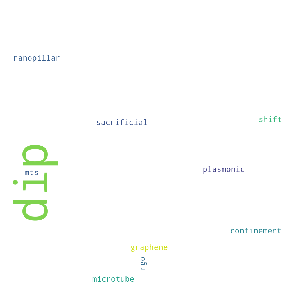

In [136]:
# plot the WordCloud image                        
plt.figure(figsize = (4, 4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 